In [46]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import torch
import librosa
from IPython.display import Audio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss, kurtosis_loss
from dstft import DSTFT, FDSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pd.options.display.width = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
x = torch.from_numpy(x).float().to(device)[None, :] 
print(sr, x.shape)

2000 torch.Size([1, 80896])


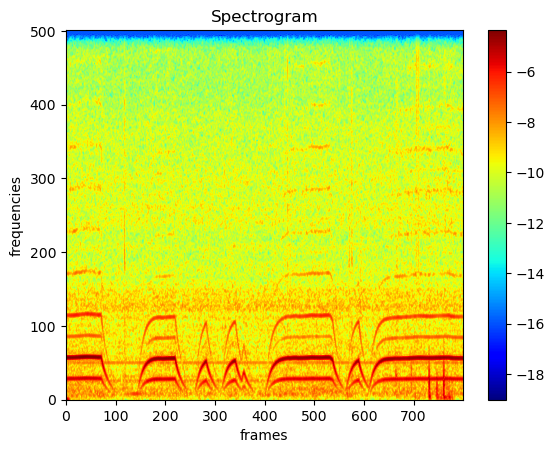

In [59]:
dstft = FDSTFT(x, win_length=500, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

Single window length

514 tensor(11.3296, device='cuda:0')


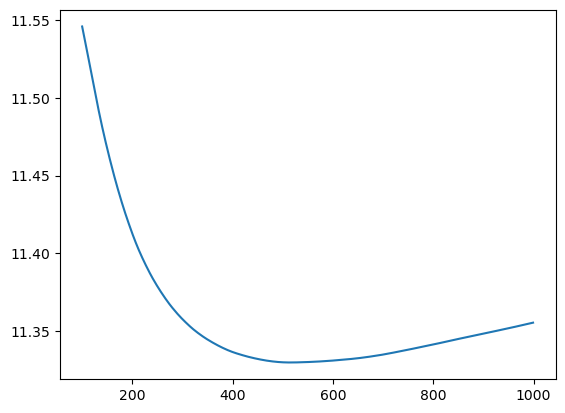

In [50]:
losses = []
min_err = 100
min_win = 0

for win_length in range(100, 1_000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=1000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    err = entropy_loss(spec) # 1_000 / kurtosis_loss(spec).mean() # entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())
    
print(min_win, min_err)
import matplotlib.pyplot as plt
plt.plot(range(100, 1000, 1), losses)

Epoch 00103: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00203: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00303: reducing learning rate of group 0 to 1.0000e-01.
302
617.3539428710938 tensor(10.6435, device='cuda:0', grad_fn=<MeanBackward0>)


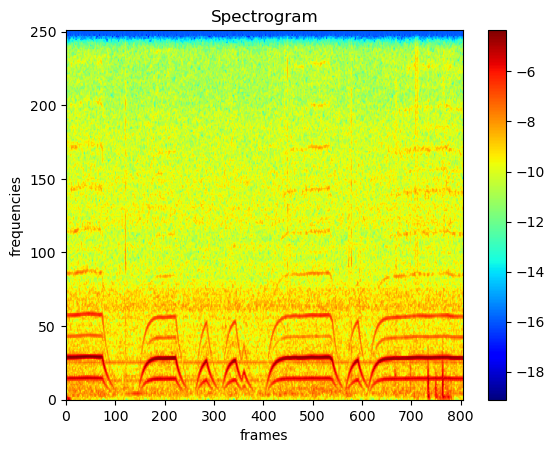

1083.7


In [51]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')

Time-varying window length

Epoch 00019: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00029: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00039: reducing learning rate of group 0 to 1.0000e-01.
38


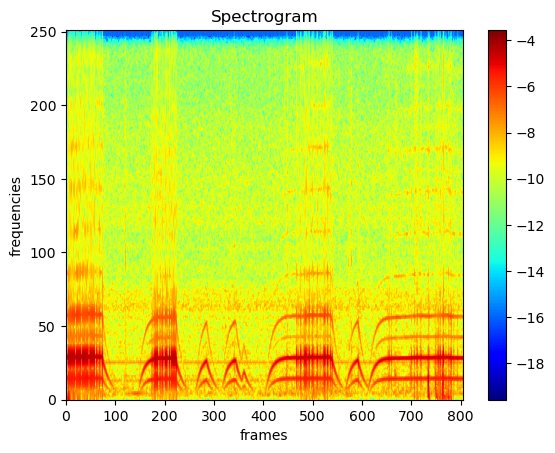

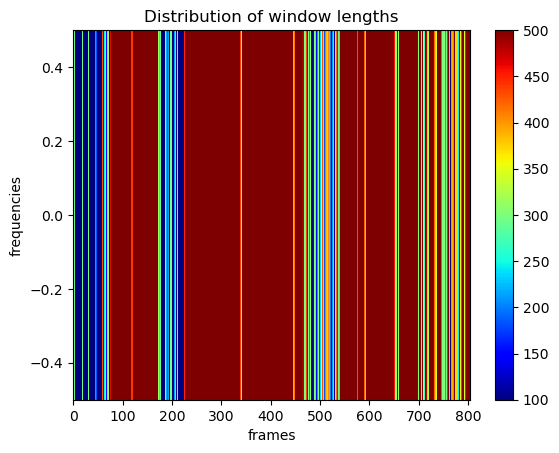

In [52]:
dstft = FDSTFT(x, win_length=300, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


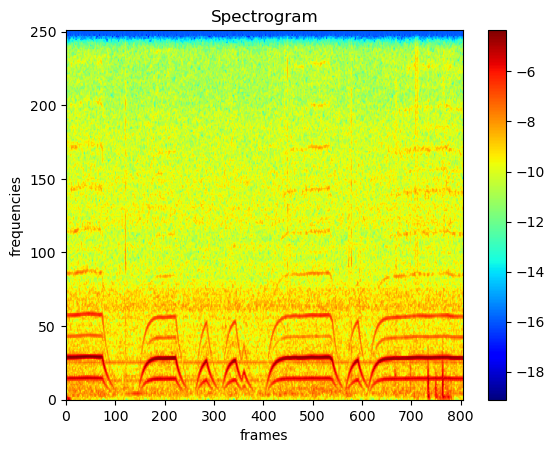

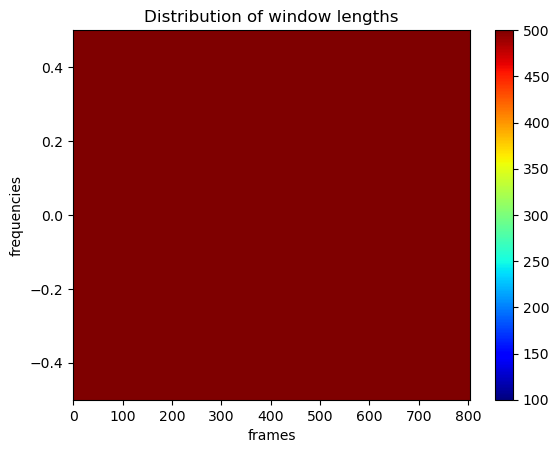

In [53]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.1 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False,)

Frequency-varying window length

In [54]:
# dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
# params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

# for epoch in range(1_000):
#     opt.zero_grad()
#     spec, *_ = dstft(x)
#     err = entropy_loss(spec)
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if opt.param_groups[0]['lr'] < 1:
#         break
    
# print(epoch)
# dstft.print(spec, x, wins=False, bar=True)


In [55]:
# dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
# params = [{'params': dstft.win_length, 'lr': 100.0},  ]
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

# for epoch in range(1_000):
#     opt.zero_grad()
#     spec, *_ = dstft(x)
#     err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if opt.param_groups[0]['lr'] < 1:
#         break
    
# print(epoch)
# dstft.print(spec, x, wins=False, bar=True)

Time-and-frequency-varying window length

Epoch 00050: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00070: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00080: reducing learning rate of group 0 to 1.0000e-01.
79


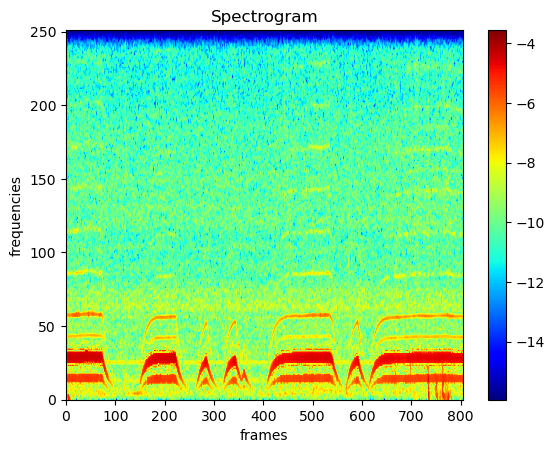

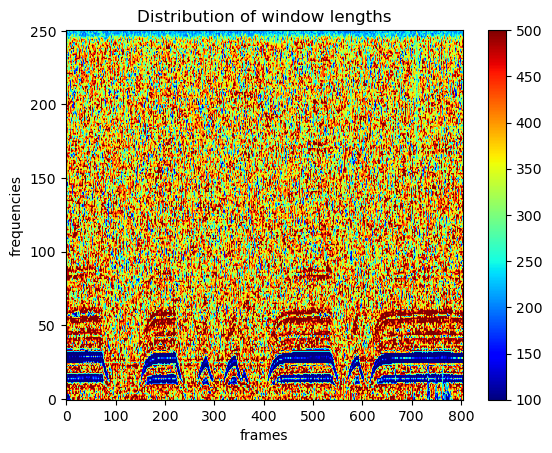

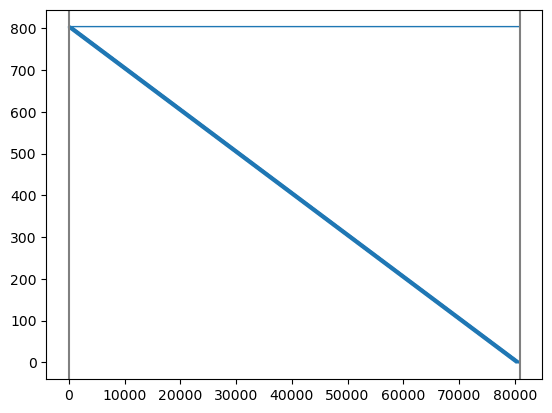

In [56]:
dstft = DSTFT(x, win_length=200, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

0 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


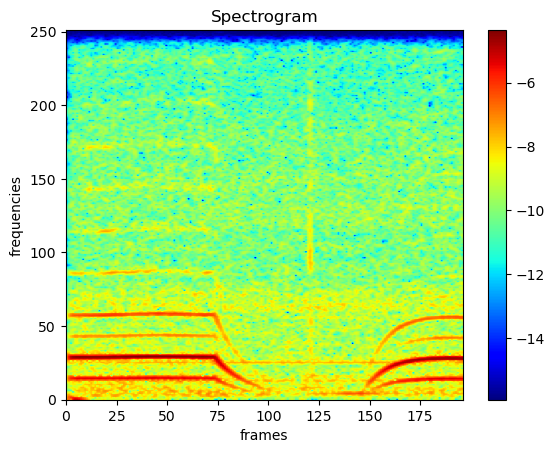

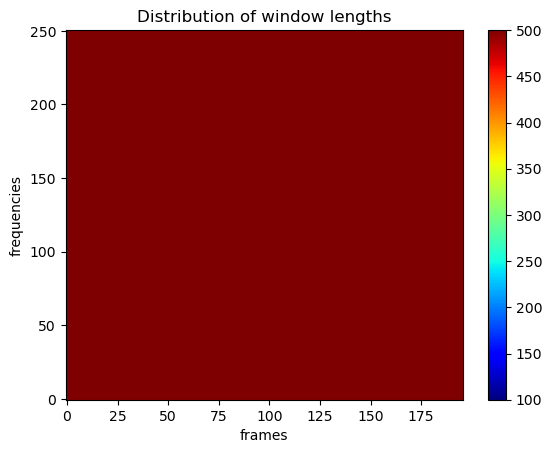

1 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


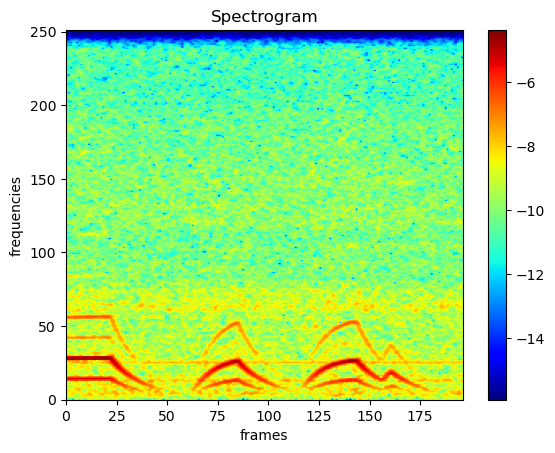

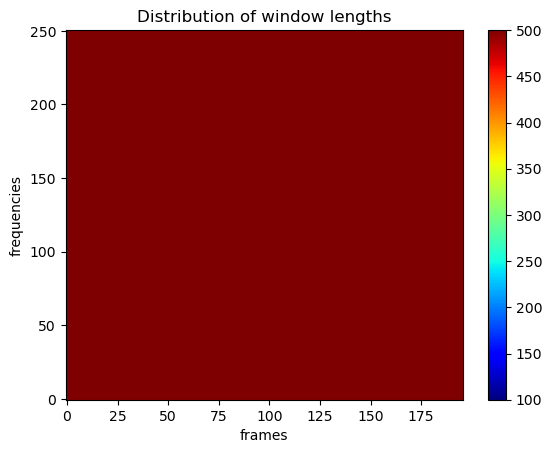

2 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


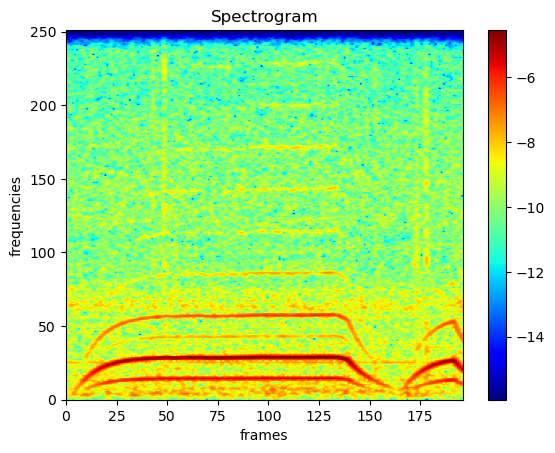

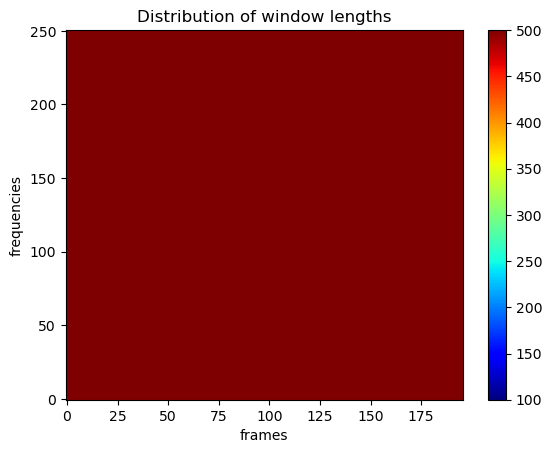

3 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


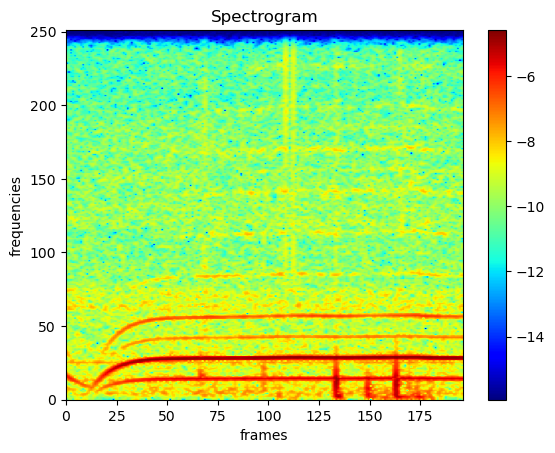

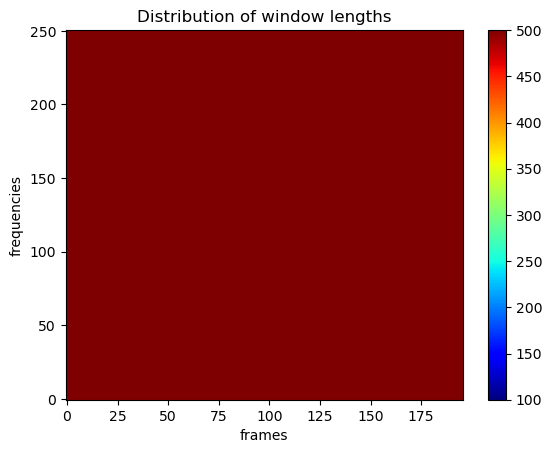

4 torch.Size([1, 896])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


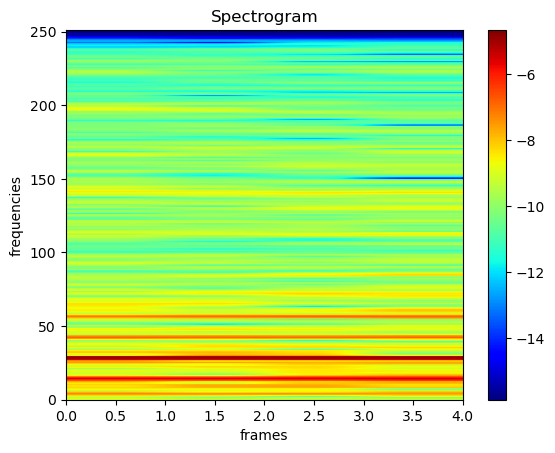

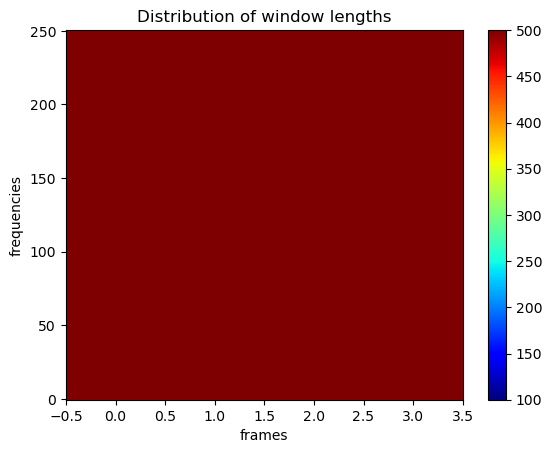

torch.Size([1, 251, 788]) torch.Size([251, 788])


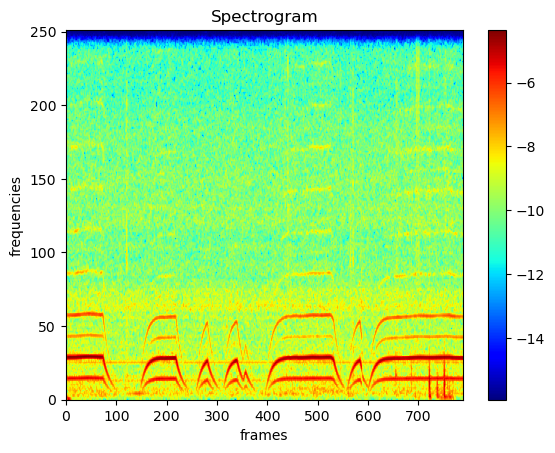

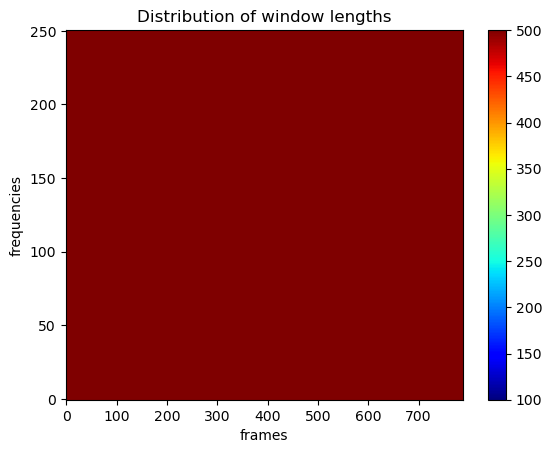

In [57]:
chunks = torch.split(x[0], 50_000)

spec_all = []
weight_all = []

for i, x_tmp in enumerate(chunks):    
    x_tmp = x_tmp[None, ...]
    print(i, x_tmp.shape)
    
    dstft = DSTFT(x_tmp, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
    params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x_tmp)
        err = entropy_loss(spec)
        err.backward()
        opt.step()
        sch.step(err)
        
        if opt.param_groups[0]['lr'] < 1:
            break
        
    print(epoch)
    dstft.print(spec, x_tmp, bar=True, wins=False)
    
    #print(spec.shape, dstft.actual_win_length[:dstft.F].detach().shape)
    spec_all.append(spec)
    weight_all.append(dstft.actual_win_length[:dstft.F].detach())
    


specs = spec_all[0]
#print(specs.shape, specs.dtype)
weights = weight_all[0]

size = len(spec_all)-1 

for i in range(size):
    specs = torch.cat((specs, spec_all[i+1]), dim=2)
    weights = torch.cat((weights, weight_all[i+1]), dim=1)

print(specs.shape, weights.shape)


plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(specs[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,specs.shape[-1], 0, specs.shape[-2]])
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()

plt.figure()
plt.title('Distribution of window lengths')
ax = plt.subplot()
im = ax.imshow(weights.detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies')
ax.set_xlabel('frames')
plt.colorbar(im, ax=ax)
im.set_clim(dstft.win_min, dstft.win_max)   
plt.show()   



0 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


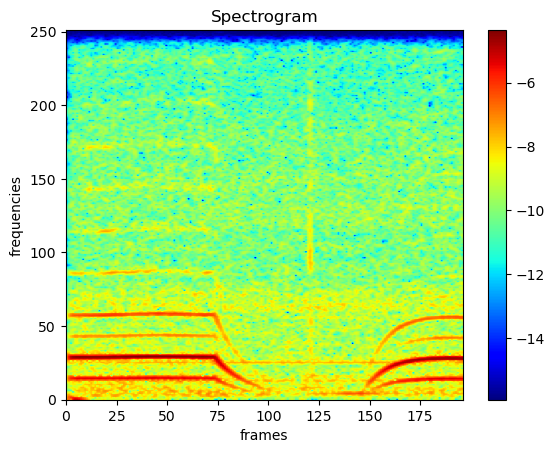

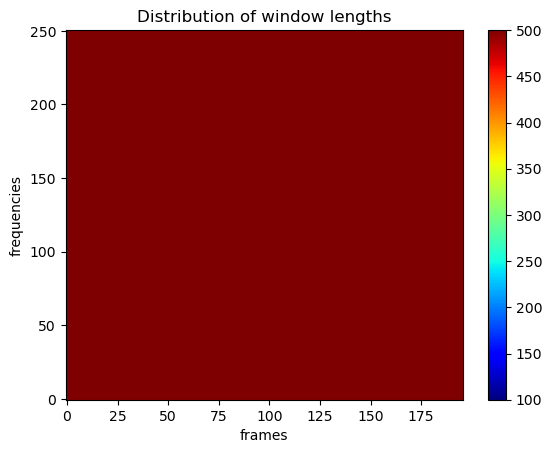

1 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


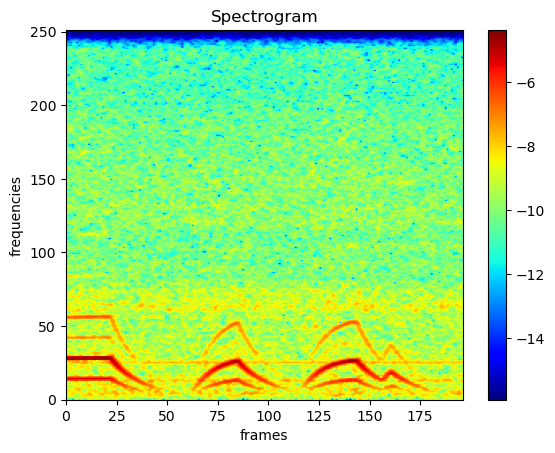

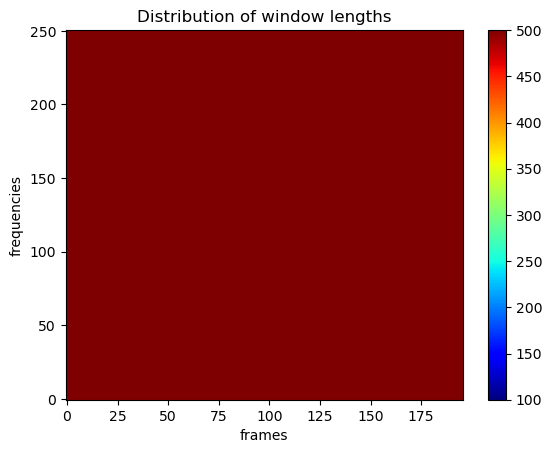

2 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


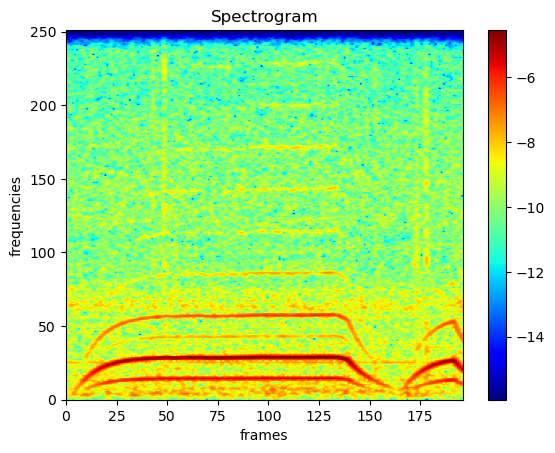

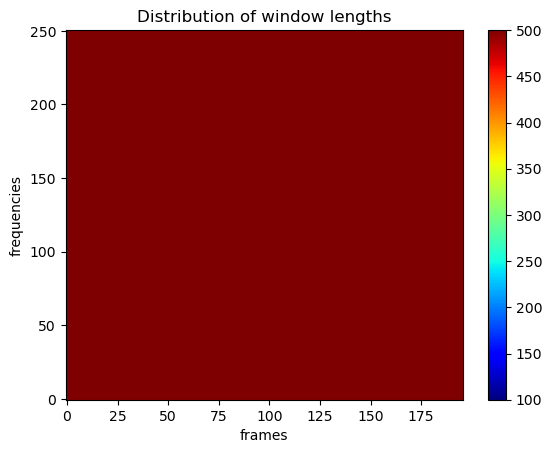

3 torch.Size([1, 20000])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


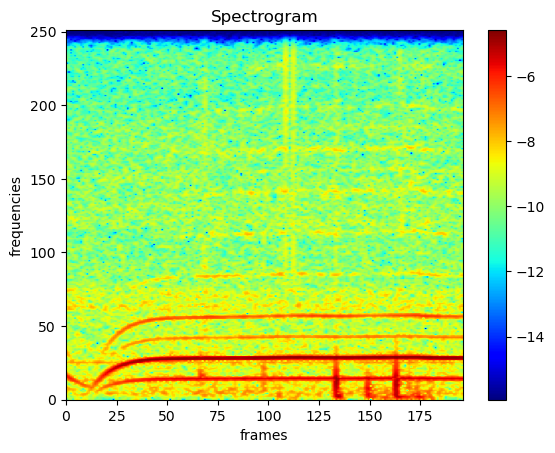

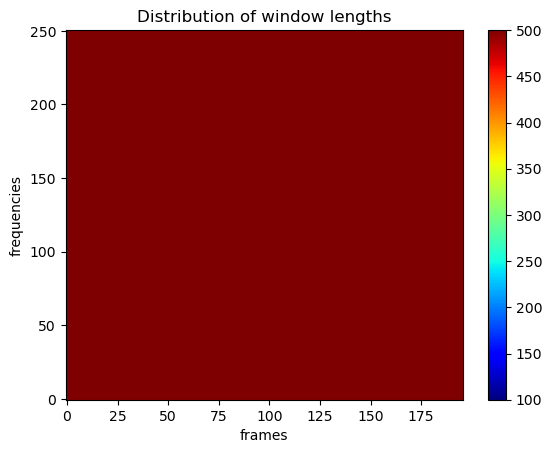

4 torch.Size([1, 896])
Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


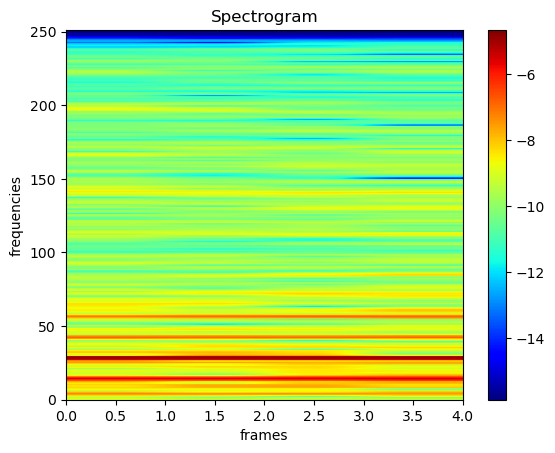

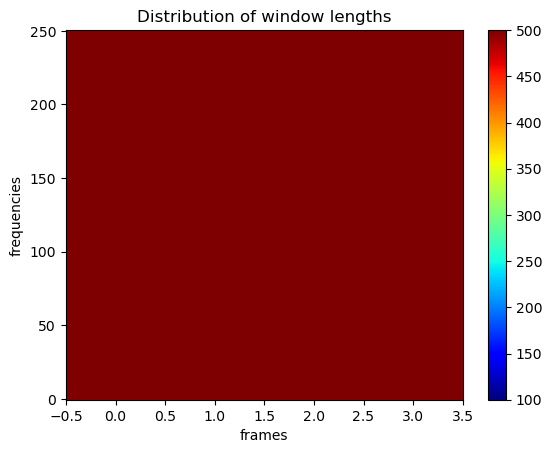

torch.Size([1, 251, 788]) torch.Size([251, 788])


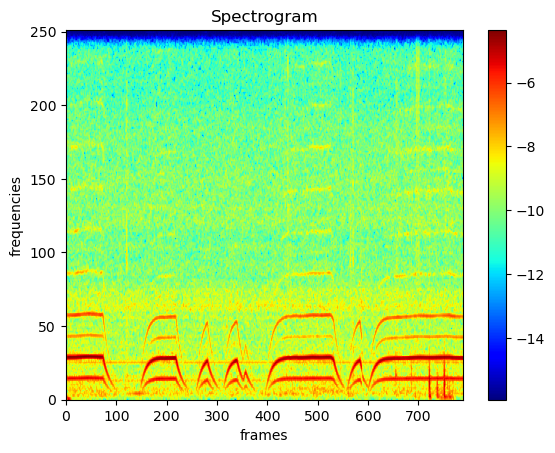

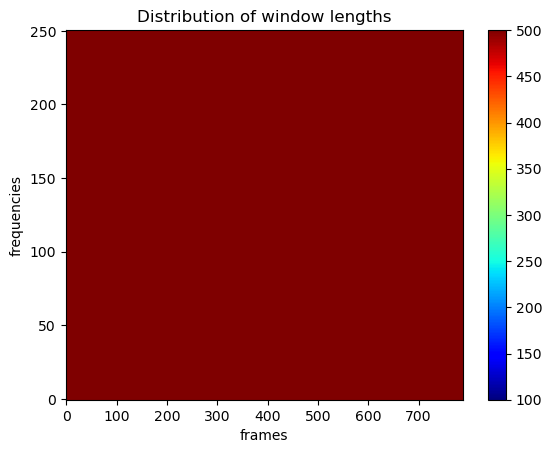

In [58]:
chunks = torch.split(x[0], 20_000)
#print(len(chunks))

spec_all = []
weight_all = []

for i, x_tmp in enumerate(chunks):    
    x_tmp = x_tmp[None, ...]
    print(i, x_tmp.shape)
    
    dstft = DSTFT(x_tmp, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
    params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

    for epoch in range(1_000):
        opt.zero_grad()
        spec, *_ = dstft(x_tmp)
        err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
        err.backward()
        opt.step()
        sch.step(err)
        
        if opt.param_groups[0]['lr'] < 1:
            break
        
    print(epoch)
    dstft.print(spec, x_tmp, bar=True, wins=False)
    
    #print(spec.shape, dstft.actual_win_length[:dstft.F].detach().shape)
    spec_all.append(spec)
    weight_all.append(dstft.actual_win_length[:dstft.F].detach())
    
#specs = torch.stack(spec_all, 2)
#weights = torch.stack(weight_all, 2)

specs = spec_all[0]
#print(specs.shape, specs.dtype)
weights = weight_all[0]

size = len(spec_all)-1 

for i in range(size):
    specs = torch.cat((specs, spec_all[i+1]), dim=2)
    weights = torch.cat((weights, weight_all[i+1]), dim=1)

print(specs.shape, weights.shape)


plt.figure()
plt.title('Spectrogram')
ax = plt.subplot()
im = ax.imshow(specs[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='jet', extent=[0,specs.shape[-1], 0, specs.shape[-2]])
plt.ylabel('frequencies')
plt.xlabel('frames')
plt.colorbar(im, ax=ax)
plt.show()

plt.figure()
plt.title('Distribution of window lengths')
ax = plt.subplot()
im = ax.imshow(weights.detach().cpu(), aspect='auto', origin='lower', cmap='jet')
ax.set_ylabel('frequencies')
ax.set_xlabel('frames')
plt.colorbar(im, ax=ax)
im.set_clim(dstft.win_min, dstft.win_max)   
plt.show()   